In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

from dotenv import load_dotenv
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score


# Load finance data from SQL

In [2]:
env_path = os.path.abspath("../.env")
load_dotenv(dotenv_path=env_path)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

finance = pd.read_sql("SELECT * FROM feature.finance", engine)
marketing = pd.read_sql("SELECT * FROM feature.marketing", engine)
feature_marketing = pd.read_sql("SELECT * FROM feature.marketing", engine)
feature_finance = pd.read_sql("SELECT * FROM feature.finance", engine)
marketing_score = pd.read_sql("SELECT * FROM marketing_scores", engine)
feature_finance_fraud = pd.read_sql("SELECT * FROM feature.finance_fraud_features", engine)
feature_marketing_fraud = pd.read_sql("SELECT * FROM feature.marketing_fraud_features", engine)
feature_fraud = pd.read_sql("SELECT * FROM feature.feature_fraud", engine)
label_fraud = pd.read_sql("SELECT * FROM label.fraud_label", engine)
feature_fraud_dataset = pd.read_sql("SELECT * FROM feature.training_fraud_dataset", engine)
finance_fraud_daily = pd.read_sql("SELECT * FROM feature.finance_fraud_daily", engine)
marketing_fraud_daily = pd.read_sql("SELECT * FROM feature.marketing_fraud_daily", engine)
feature_fraud_daily = pd.read_sql("SELECT * FROM feature.feature_fraud_daily", engine)
fraud_label_daily = pd.read_sql("SELECT * FROM label.fraud_label_daily", engine)
training_fraud_daily = pd.read_sql("SELECT * FROM feature.training_fraud_daily", engine)
daily_fraud_alert = pd.read_sql("SELECT * FROM alert.daily_fraud_alert", engine)
pd.set_option('display.max_columns', None)

OperationalError: (psycopg2.OperationalError) connection to server at "localhost" (::1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
# main dataset
df = feature_fraud_dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              41188 non-null  object 
 1   event_date           41188 non-null  object 
 2   tx_count             41188 non-null  int64  
 3   total_tx_amount      41188 non-null  float64
 4   avg_tx_amount        41188 non-null  float64
 5   max_tx_amount        41188 non-null  float64
 6   std_tx_amount        41188 non-null  float64
 7   avg_account_balance  41188 non-null  float64
 8   total_clicks         41188 non-null  int64  
 9   total_impressions    41188 non-null  int64  
 10  total_conversion     41188 non-null  int64  
 11  ctr                  41188 non-null  float64
 12  weekday              41188 non-null  float64
 13  month                41188 non-null  float64
 14  year                 41188 non-null  float64
 15  fraud_score          41188 non-null 

In [ ]:
df

,user_id,event_date,tx_count,total_tx_amount,avg_tx_amount,max_tx_amount,std_tx_amount,avg_account_balance,total_clicks,total_impressions,total_conversion,ctr,weekday,month,year,fraud_score,fraud_label
0,AA13249,2025-12-25,464,234972720.0,506406.724138,4963146.0,1.040360e+06,575492.148707,222,1,0,222.000000,4.0,12.0,2025.0,231.800711,0
1,AA16259,2025-12-25,464,234972720.0,506406.724138,4963146.0,1.040360e+06,575492.148707,237,1,0,237.000000,4.0,12.0,2025.0,246.800711,0
2,AA35121,2025-12-25,464,234972720.0,506406.724138,4963146.0,1.040360e+06,575492.148707,133,1,0,133.000000,4.0,12.0,2025.0,142.800711,0
3,AA23441,2025-12-25,464,234972720.0,506406.724138,4963146.0,1.040360e+06,575492.148707,167,7,0,23.857143,4.0,12.0,2025.0,33.657854,0
4,AA19754,2025-12-25,464,234972720.0,506406.724138,4963146.0,1.040360e+06,575492.148707,243,1,0,243.000000,4.0,12.0,2025.0,252.800711,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,AA8156,2025-12-25,464,234972720.0,506406.724138,4963146.0,1.040360e+06,575492.148707,73,1,0,73.000000,4.0,12.0,2025.0,82.800711,0
41184,AA22986,2025-12-25,464,234972720.0,506406.724138,4963146.0,1.040360e+06,575492.148707,153,5,0,30.600000,4.0,12.0,2025.0,40.400711,0
41185,AA19073,2025-12-25,464,234972720.0,506406.724138,4963146.0,1.040360e+06,575492.148707,196,1,0,196.000000,4.0,12.0,2025.0,205.800711,0
41186,AA37743,2025-12-25,464,234972720.0,506406.724138,4963146.0,1.040360e+06,575492.148707,64,1,0,64.000000,4.0,12.0,2025.0,73.800711,0


In [ ]:
# Feature engineering for datetime
df['event_date'] = pd.to_datetime(df['event_date'])
df['Day'] = df['event_date'].dt.day

df = df.drop(columns=['event_date'])

In [ ]:
df['fraud_label'].value_counts()

fraud_label
0    32925
1     8263
Name: count, dtype: int64

In [ ]:
df.isnull().sum()

user_id                0
tx_count               0
total_tx_amount        0
avg_tx_amount          0
max_tx_amount          0
std_tx_amount          0
avg_account_balance    0
total_clicks           0
total_impressions      0
total_conversion       0
ctr                    0
weekday                0
month                  0
year                   0
fraud_score            0
fraud_label            0
Day                    0
dtype: int64

# Feature Target

In [ ]:
TARGET = "fraud_label"

X = df.drop(columns=[TARGET, "user_id"])
y = df[TARGET]

# Target split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scalling data

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modeling

In [ ]:
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1024      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3137 (12.25 KB)
Trainable params: 3137 (12.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2025-12-27 02:34:21.577164: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-27 02:34:21.577288: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-27 02:34:21.577293: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-27 02:34:21.577327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-27 02:34:21.577342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Training model

In [ ]:
# using callbacks for stopping training when no improvement in validation AUC
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=5,
        mode='max',
        restore_best_weights=True
    )
]

history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50


2025-12-27 02:34:21.997004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1030/1030 [==============================] - 10s 9ms/step - loss: 0.0459 - auc: 0.9997 - precision: 0.9631 - recall: 0.9939 - val_loss: 0.0135 - val_auc: 1.0000 - val_precision: 0.9922 - val_recall: 0.9976
Epoch 2/50
1030/1030 [==============================] - 10s 10ms/step - loss: 0.0102 - auc: 0.9999 - precision: 0.9911 - recall: 0.9924 - val_loss: 0.0098 - val_auc: 1.0000 - val_precision: 0.9969 - val_recall: 0.9879
Epoch 3/50
1030/1030 [==============================] - 11s 10ms/step - loss: 0.0082 - auc: 0.9997 - precision: 0.9944 - recall: 0.9946 - val_loss: 0.0099 - val_auc: 1.0000 - val_precision: 0.9758 - val_recall: 1.0000
Epoch 4/50
1030/1030 [==============================] - 10s 10ms/step - loss: 0.0059 - auc: 1.0000 - precision: 0.9949 - recall: 0.9953 - val_loss: 0.0052 - val_auc: 1.0000 - val_precision: 0.9970 - val_recall: 1.0000
Epoch 5/50
1030/1030 [==============================] - 11s 10ms/step - loss: 0.0055 - auc: 1.0000 - precision: 0.9940 - recall: 0.9958 - va

# Evaluation

In [ ]:
y_pred_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred))

# ROC AUC only can be calculated using predicted probabilities
if len(np.unique(y_test)) >1:
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))
else:
    print("ROC AUC Score: Cannot be calculated, only one class present in y_test.")
    print(f"Test set class distribution: {np.unique(y_test, return_counts=True)}")


258/258 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6585
           1       1.00      1.00      1.00      1653

    accuracy                           1.00      8238
   macro avg       1.00      1.00      1.00      8238
weighted avg       1.00      1.00      1.00      8238

ROC AUC Score: 1.0


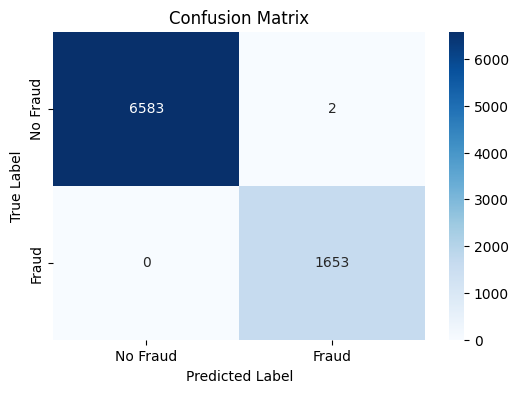

In [ ]:
# visualization for confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save model